# Storing Classification Reports

Create a global list for that 

In [1]:
## Storage for all classification reports

all_reports =[]
def store_report(report_dict, model_name, phase, storage_list,
                 U_min=None, U_max=None, mu_min=None, mu_max=None, U_step=None, mu_step=None):
    """
    Store classification report with model, phase, and grid parameters.
    """
    for cls, metrics in report_dict.items():
        if isinstance(metrics, dict): # per-class or averages
            storage_list.append({
                "Model": model_name,
                "Phase": phase,
                "Class": str(cls),
                "precision": metrics.get("precision"),
                "recall": metrics.get("recall"),
                "f1-score": metrics.get("f1-score"),
                "support": metrics.get("support"),
                "U_min": U_min, "U_max": U_max,
                "mu_min": mu_min, "mu_max": mu_max,
                "U_step": U_step, "mu_step": mu_step
            })
        else:                # e.g. "accuracy": float
            storage_list.append({
                "Model": model_name,
                "Phase": phase,
                "Class": str(cls),
                "precision": None,
                "recall": None,
                "f1-score": metrics,
                "support": None,
                "U_min": U_min, "U_max": U_max,
                "mu_min": mu_min, "mu_max": mu_max,
                "U_step": U_step, "mu_step": mu_step
            })


# def store_report(report_dict, model_name, phase, storage_list):
#     """
#     Convert classification_report (output_dict=True) into a flat list of dicts
#     with Model and Phase tags, and append to storage_list.
#     """
#     for cls, metrics in report_dict.items():
#         if isinstance(metrics, dict):  # normal per-class or avg metrics
#             storage_list.append({
#                 "Model": model_name,
#                 "Phase": phase,
#                 "Class": str(cls),
#                 "precision": metrics.get("precision", None),
#                 "recall": metrics.get("recall", None),
#                 "f1-score": metrics.get("f1-score", None),
#                 "support": metrics.get("support", None)
#             })
#         else:  # sometimes accuracy is just a float
#             storage_list.append({
#                 "Model": model_name,
#                 "Phase": phase,
#                 "Class": str(cls),
#                 "precision": None,
#                 "recall": None,
#                 "f1-score": metrics,
#                 "support": None
#             })

In [2]:
print(all_reports)

[]


# Import Libraries

In [3]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Function To Train and Test the model

In [4]:
def run_models(
    models,X ,y ,
    U_min=0.0, U_max=15.0, 
    mu_min=0.0, mu_max=50.0, 
    U_step=0.1, mu_step=0.1
):
    """
    Run training, evaluation, decision boundary plotting, and prediction reports.
    Default grid limits: U∈[0,15], μ∈[0,50], step=0.1.
    Override using keyword args, e.g. run_models(models, U_max=25, mu_max=60).
    """


    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25, random_state=42,
        stratify=y
    )

    #Plot True phase diagram
    plt.figure(figsize=(9,6))
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue','red']))
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū"); plt.ylabel("μ̄")
    plt.title("True Phase Diagram")
    plt.grid(True)
    plt.show()
 
    '''
    ---------- 3) Train + Evaluate ----------
    '''

    # ---------- 4) Plot decision boundary on training domain ----------
    def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
        x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
        y_min, y_max = X["Mubar"].min(), X["Mubar"].max()

        # Clip negatives if needed
        x_min = max(0, x_min)
        y_min = max(0, y_min)


        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, grid_res),
            np.linspace(y_min, y_max, grid_res)
        )
        grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
        Z = model.predict(grid_df).reshape(xx.shape)
    
    
        plt.figure(figsize=(9, 6))
        plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)

            # Filter training points so negative μ̄ don’t affect the axis
        mask = X["Mubar"] >= 0
        plt.scatter(
            X.loc[mask, "Ubar"], 
            X.loc[mask, "Mubar"], 
            c=y.loc[mask],
            s=10, cmap=ListedColormap(['blue', 'red']),
            edgecolor='k', linewidth=0.2
        )
        # plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
        plt.clim(-0.5, 1.5)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title(title)
        plt.grid(True)
        plt.show()

        
    # def train_test(models,X_tain,y_train):
    for name, model in models.items():
            model.fit(X_train, y_train)

            # Plot Training Results 
            
            # plot_decision_boundary(model, X, y, title="T", grid_res=300):
            
            y_pred = model.predict(X_test)
            print(f"\n📊 Classification Report for {name}:")
            report_test = classification_report(y_test, y_pred, digits=4, output_dict=True)
            store_report(report_test, name, "test", all_reports,
                         U_min, U_max, mu_min, mu_max, U_step, mu_step)
            print(classification_report(y_test, y_pred, digits=4))
    
        
    
    
    for name,model  in models.items():
        # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
        clf = model  # or "LogReg-Poly2" or "RF-Shallow"
        
        plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
        
        # # ---------- 5) Predict on an extended grid (extrapolation) ----------
        # U_min, U_max = 0.0, 15.0   # extend beyond training range
        # mu_min, mu_max = 0.0, 50.0
        # U_step, mu_step = 0.1, 0.1
    
        
        U_vals = np.arange(U_min, U_max + U_step, U_step)
        mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
        U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
        
        grid_ext = pd.DataFrame({
            "Ubar": U_grid.ravel(),
            "Mubar": mu_grid.ravel()
        })
        
        pred_ext = clf.predict(grid_ext)
    
        phase_map = pred_ext.reshape(U_grid.shape)
        
        plt.figure(figsize=(9, 6))

        # if we want to see the predict of unknown datapoints and tarining prediction on the known datapoints comparisions
        # # Background prediction (gray/orange)
        # plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
        
        # # Overlay true training data (blue/red)
        # plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        

        plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
        plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
        plt.clim(-0.5, 1.5)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title("Predicted Phase Diagram for Model ")
        plt.grid(True)
        plt.show()
        
        # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
        # Only compare inside the original data domain (U≤15, μ≤50)
        mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
        grid_in_domain = grid_ext[mask_domain].copy()
        pred_in_domain = clf.predict(grid_in_domain)
          
       
        df_lookup = df.copy()
        df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
        df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
        lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
        lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
        
        grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
        grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
        true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
        
        # Drop NaNs (grid points that don't map exactly to a dataset point)
        valid = ~pd.isna(true_labels)
        true_labels = true_labels[valid].astype(int)
        pred_labels = pred_in_domain[valid]
        
        print(f"\n📊 Classification Report For Prediction using Model {name} :")
        report_pred = classification_report(true_labels, pred_labels, digits=4, output_dict=True)
        store_report(report_pred, name, "prediction", all_reports,
                     U_min, U_max, mu_min, mu_max, U_step, mu_step)
        print(classification_report(true_labels, pred_labels, digits=4))


In [5]:
def plot_phase_diagrams(models, X, y, U_min=0.0, U_max=15.0, mu_min=0.0, mu_max=50.0, U_step=0.1, mu_step=0.1):
    """
    Plot true phase diagram, training predictions, and testing predictions for each model.
    """
    from matplotlib.colors import ListedColormap
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # 1) Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # 2) Plot True Phase Diagram
    plt.figure(figsize=(9,6))
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['green','yellow']))
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    # plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("True Phase Diagram")
    plt.grid(True)
    plt.show()

    # 3) Train models and plot predictions
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        # ----- Training Predictions -----
        # Generate a grid over training domain
        x_min, x_max = X_train["Ubar"].min(), X_train["Ubar"].max()
        y_min, y_max = X_train["Mubar"].min(), X_train["Mubar"].max()
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 300),
            np.linspace(y_min, y_max, 300)
        )
        grid_train = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
        Z_train = model.predict(grid_train).reshape(xx.shape)

        plt.figure(figsize=(9,6))
        plt.contourf(xx, yy, Z_train, cmap=ListedColormap(['gray','orange']), alpha=0.7)
        plt.scatter(X_train["Ubar"], X_train["Mubar"], c=y_train, s=20, cmap=ListedColormap(['blue','red']), edgecolor='k', linewidth=0.2)
        plt.colorbar(ticks=[0,1], label="Phase (0=Mott,1=SF)")
        plt.clim(-0.5,1.5)
        plt.xlabel("Ū"); plt.ylabel("μ̄")
        plt.title(f"{name} - Training Predictions")
        plt.grid(True)
        plt.show()

        # ----- Testing Predictions -----
        y_test_pred = model.predict(X_test)
        plt.figure(figsize=(9,6))
        plt.scatter(X_test["Ubar"], X_test["Mubar"], c=y_test_pred, s=20, cmap=ListedColormap(['green','yellow']), edgecolor='k', linewidth=0.2)
        plt.xlabel("Ū"); plt.ylabel("μ̄")
        plt.title(f"{name} - Testing Predictions")
        plt.grid(True)
        plt.show()
        
        # ----- Optional: Classification Report -----
        print(f"\n📊 Classification Report for {name} on Testing Data:")
        print(classification_report(y_test, y_test_pred, digits=4))


# Loading the dataset for u<=15 and Mu<=50 dataset

# Deafult MLP with mu<=50 and u<=15 dataset

- The Problem with this is even though its good for predicying the training dataset its bad for predicting unknown points
- It fails mostly at g=3 **this Is Expected**
1. Because its given Less training g=3 mott insulator
2. And also Pointy Curve because of the same

**Soultion:
Use a Bigger dataset**

In [37]:
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9992    0.9884    0.9938      8704
           1     0.9902    0.9993    0.9947     10209

    accuracy                         0.9943     18913
   macro avg     0.9947    0.9939    0.9942     18913
weighted avg     0.9943    0.9943    0.9943     18913



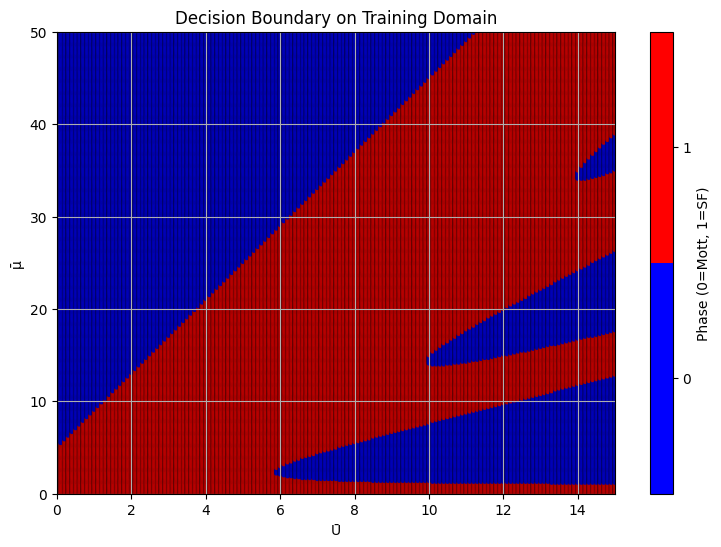

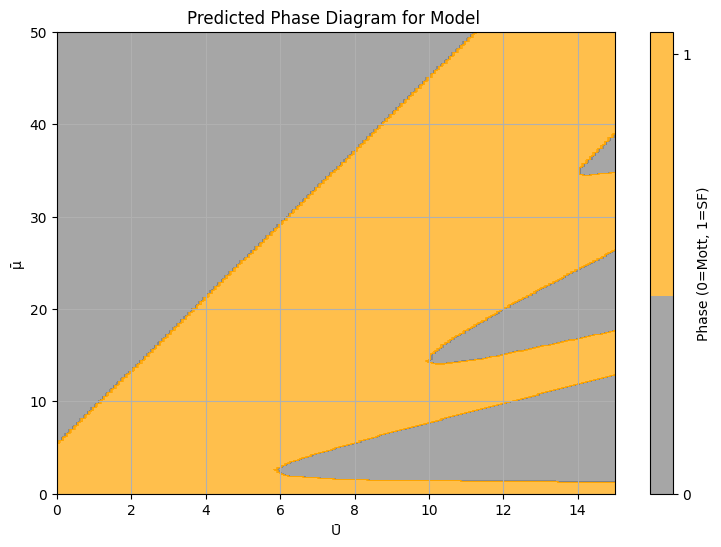


📊 Classification Report For Prediction using Model MLP :
              precision    recall  f1-score   support

           0     0.9995    0.9888    0.9941     34816
           1     0.9905    0.9996    0.9950     40835

    accuracy                         0.9946     75651
   macro avg     0.9950    0.9942    0.9946     75651
weighted avg     0.9947    0.9946    0.9946     75651



In [6]:

# Model 
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

models = {
    "MLP": mlp
}

run_models(models,X,y) 

## Prediction for unknown datapoints


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9992    0.9884    0.9938      8704
           1     0.9902    0.9993    0.9947     10209

    accuracy                         0.9943     18913
   macro avg     0.9947    0.9939    0.9942     18913
weighted avg     0.9943    0.9943    0.9943     18913



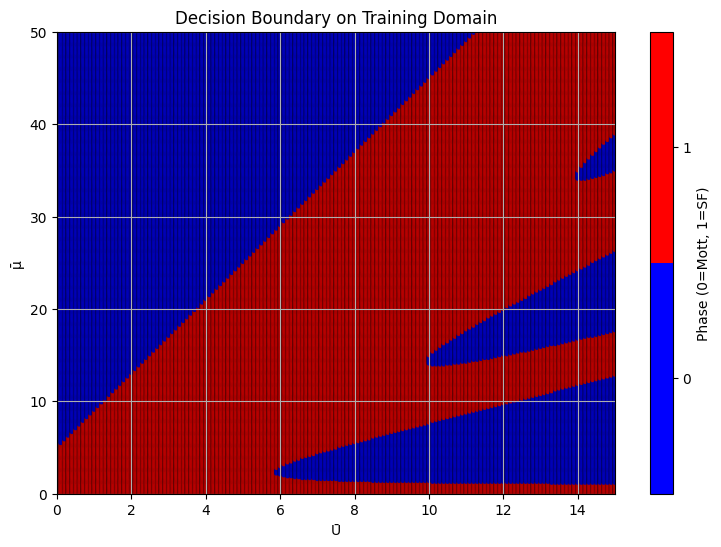

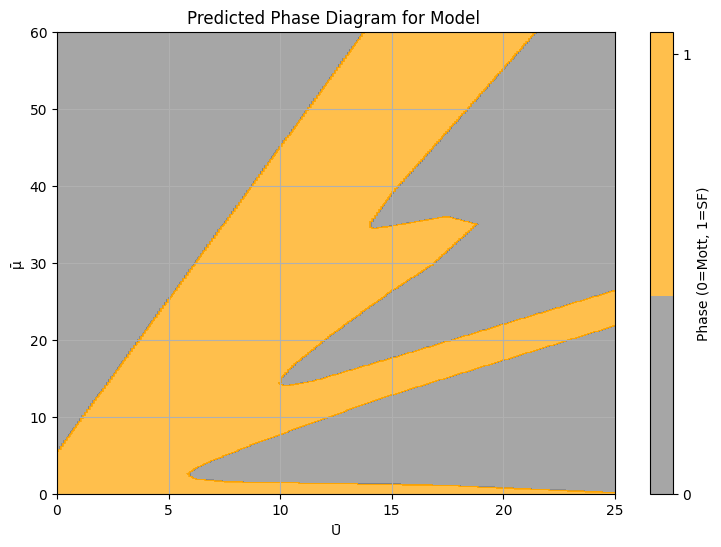


📊 Classification Report For Prediction using Model MLP :
              precision    recall  f1-score   support

           0     0.9995    0.9888    0.9941     34816
           1     0.9905    0.9996    0.9950     40835

    accuracy                         0.9946     75651
   macro avg     0.9950    0.9942    0.9946     75651
weighted avg     0.9947    0.9946    0.9946     75651



In [7]:

# Model 
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

models = {
    "MLP": mlp
}

run_models(models, X, y, U_max=25, mu_max=60)

# The Same MLP with Larger Dataset u<=25.0 and mu<=60 

- Comparitively this one gives yeilds better prediction results  as expected

In [9]:

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

print( " Initial Data", df)

# --- pick extremes ---
df_extremes = df[
    ((df["Phi2"] < 1e-8) & (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3)))  # deep MI
    | (df["Phi2"] > 1e-2)  # deep SF
]

# --- pick near-boundary points ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)   # small but nonzero phi2
]

# --- sample safely ---
n_ext = min(2000, len(df_extremes))
n_bnd = min(5000, len(df_boundary))

df_reduced = pd.concat([
    df_extremes.sample(n_ext, random_state=42),
    df_boundary.sample(n_bnd, random_state=42)
])

# Use this reduced datase
df = df_reduced.reset_index(drop=True)

print("extreme datapoints  ( reduced dataset)",df)


 Initial Data           t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0

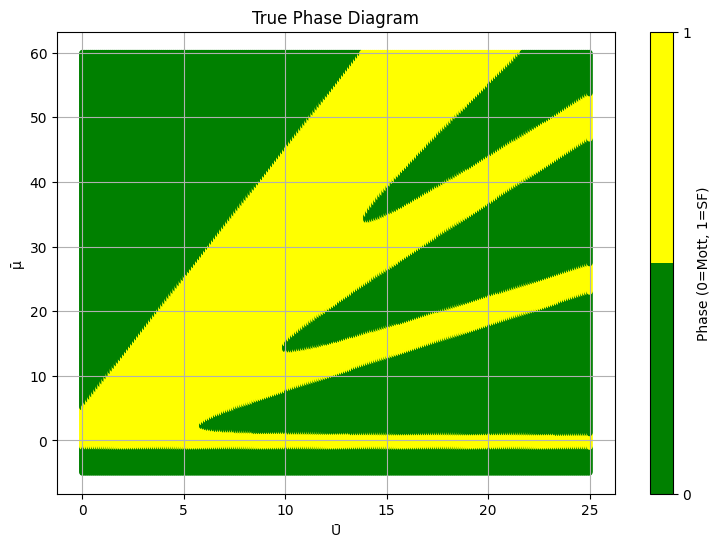

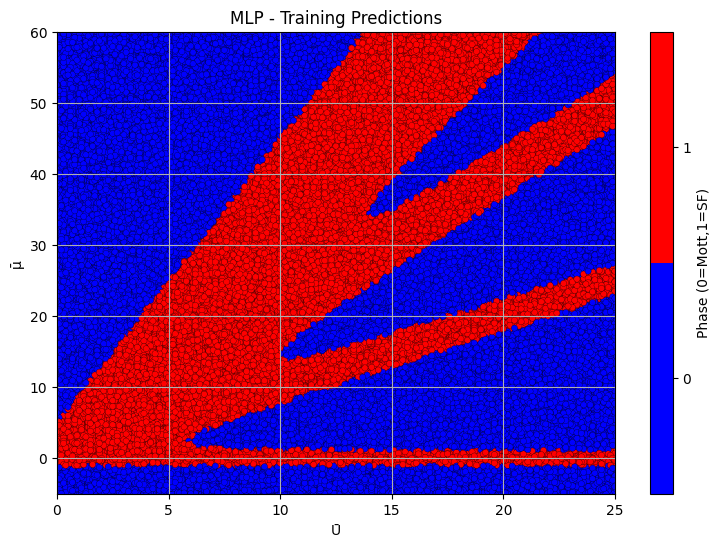

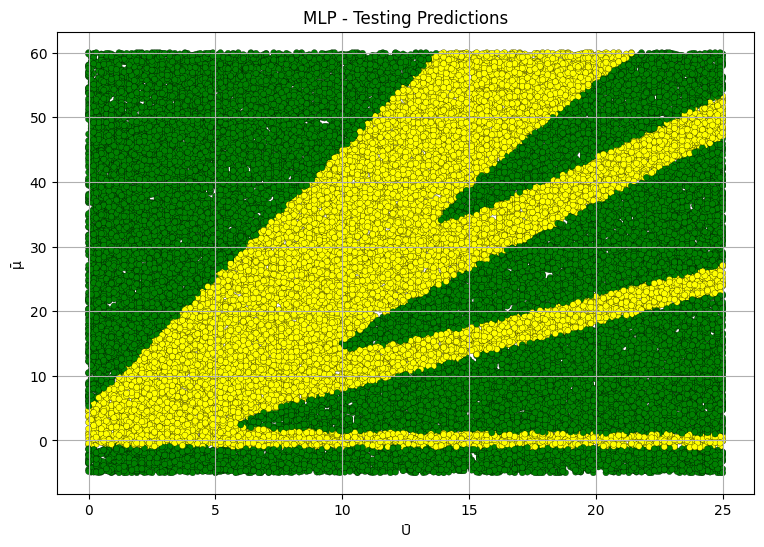


📊 Classification Report for MLP on Testing Data:
              precision    recall  f1-score   support

           0     0.9889    0.9984    0.9936     24363
           1     0.9976    0.9835    0.9905     16488

    accuracy                         0.9924     40851
   macro avg     0.9933    0.9910    0.9921     40851
weighted avg     0.9924    0.9924    0.9924     40851



In [7]:

# Model 
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

models = {
    "MLP": mlp
}

plot_phase_diagrams(models, X, y,U_max=25, mu_max=60)

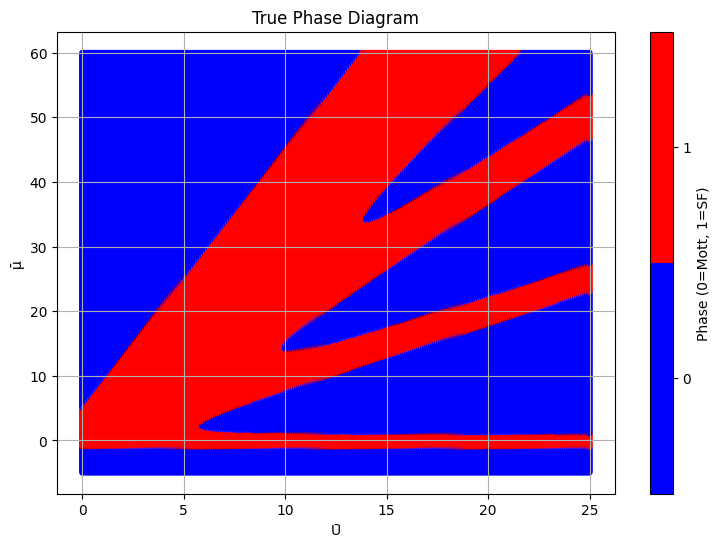


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9889    0.9984    0.9936     24363
           1     0.9976    0.9835    0.9905     16488

    accuracy                         0.9924     40851
   macro avg     0.9933    0.9910    0.9921     40851
weighted avg     0.9924    0.9924    0.9924     40851



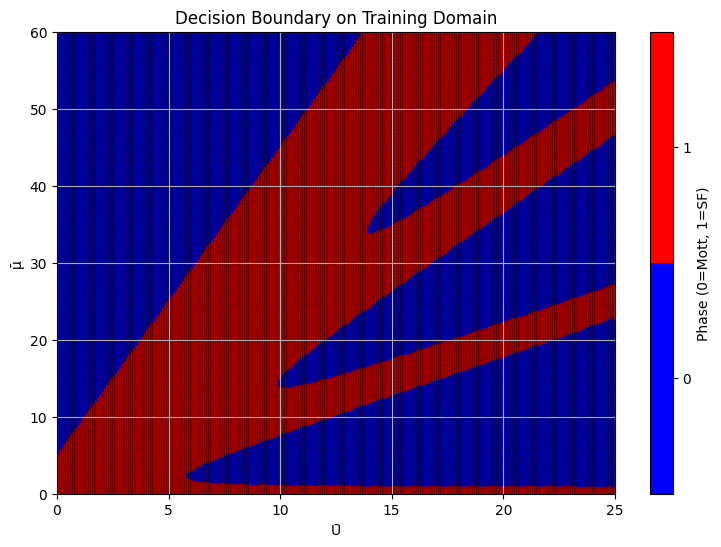

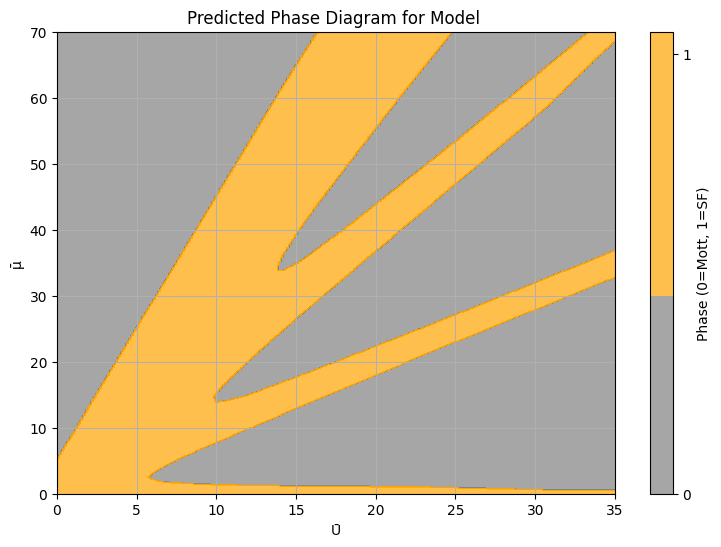


📊 Classification Report For Prediction using Model MLP :
              precision    recall  f1-score   support

           0     0.8035    1.0000    0.8911      1051
           1     1.0000    0.7929    0.8845      1241

    accuracy                         0.8879      2292
   macro avg     0.9018    0.8965    0.8878      2292
weighted avg     0.9099    0.8879    0.8875      2292



In [8]:

# Model 
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

models = {
    "MLP": mlp
}

run_models(models, X, y,U_max=35, mu_max=70)

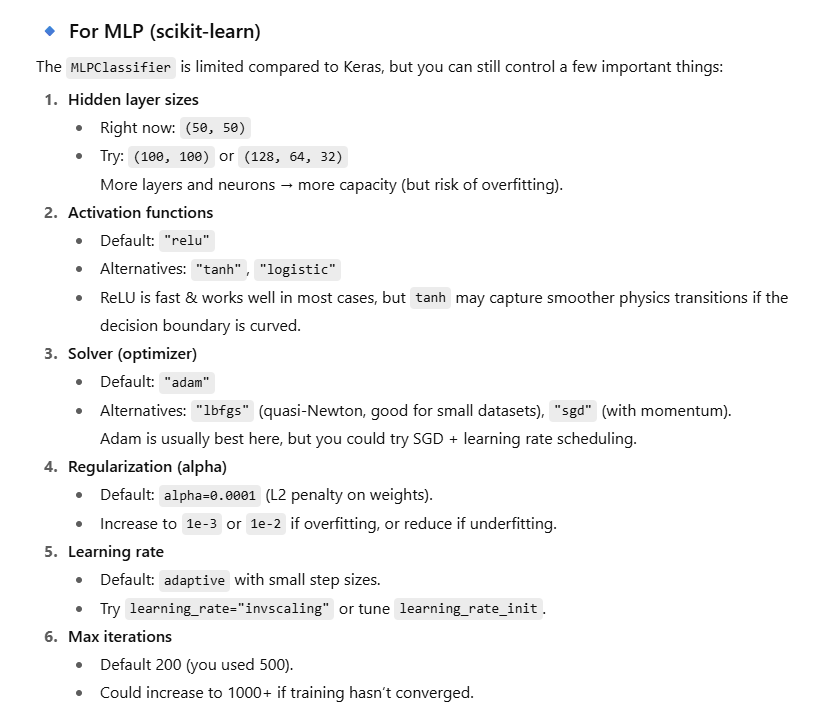


# Hidden Layer sizes 

## (100,100)


📊 Classification Report for MLP_with_(100,100):
              precision    recall  f1-score   support

           0     0.9917    0.9945    0.9931     24363
           1     0.9918    0.9876    0.9897     16488

    accuracy                         0.9917     40851
   macro avg     0.9917    0.9910    0.9914     40851
weighted avg     0.9917    0.9917    0.9917     40851



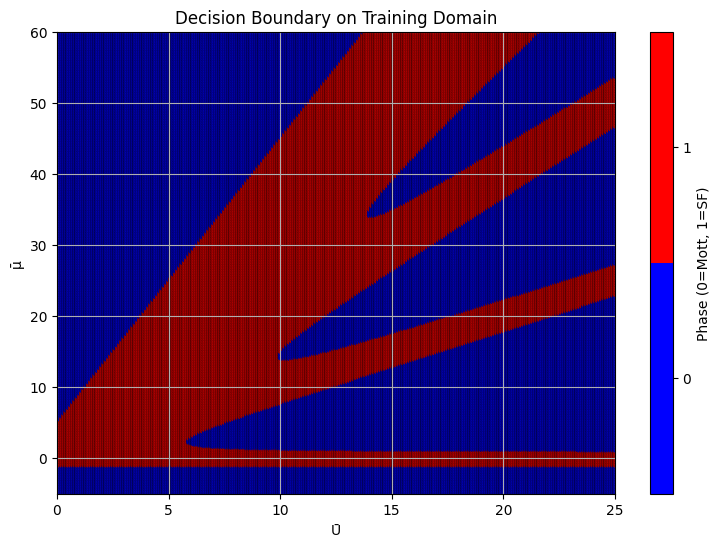

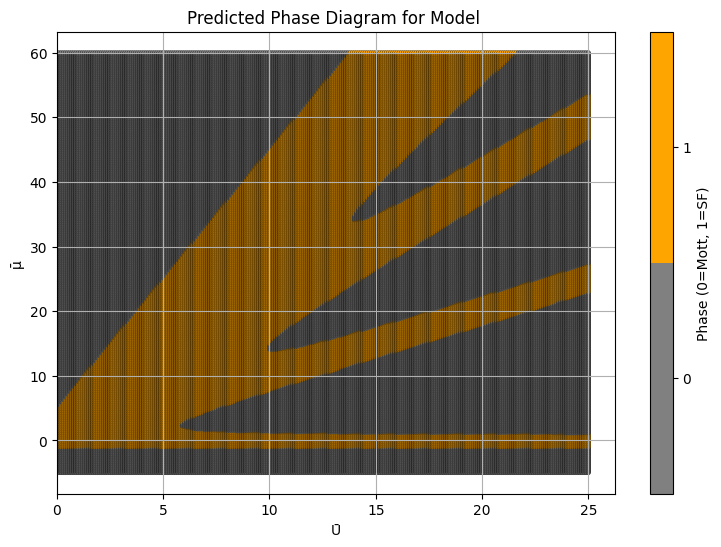


📊 Classification Report For Prediction using Model MLP_with_(100,100) :
              precision    recall  f1-score   support

           0     0.9928    0.9983    0.9956     34816
           1     0.9985    0.9939    0.9962     40835

    accuracy                         0.9959     75651
   macro avg     0.9957    0.9961    0.9959     75651
weighted avg     0.9959    0.9959    0.9959     75651



In [12]:
mlp_100 = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42))
    ])

models = {
    "MLP_with_(100,100)": mlp_100

}

run_models(models,X,y)

## (128, 64, 32) (decreasing pyramid)


📊 Classification Report for MLP_(128,64,32):
              precision    recall  f1-score   support

           0     0.9736    0.9959    0.9847     24363
           1     0.9938    0.9602    0.9767     16488

    accuracy                         0.9815     40851
   macro avg     0.9837    0.9780    0.9807     40851
weighted avg     0.9818    0.9815    0.9814     40851



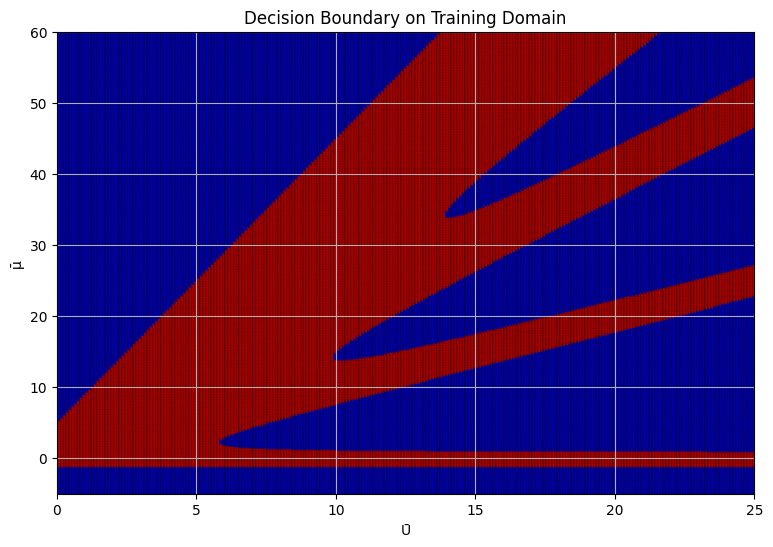

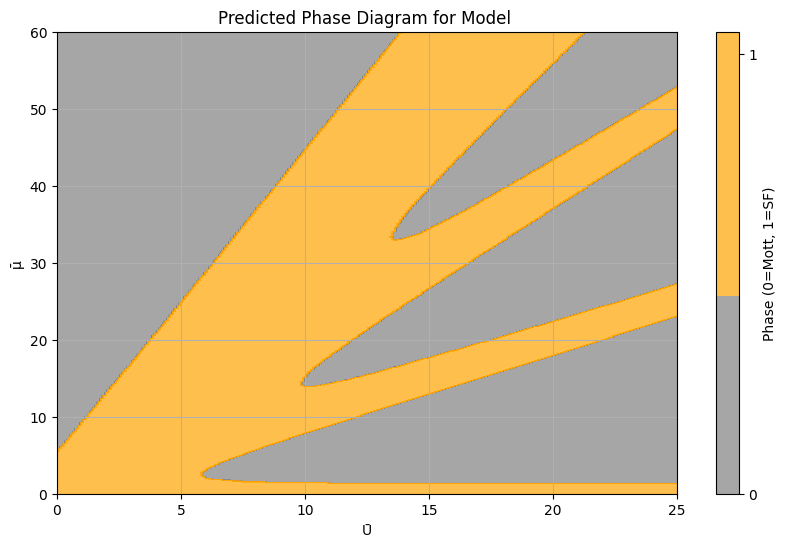


📊 Classification Report For Prediction using Model MLP_(128,64,32):
              precision    recall  f1-score   support

           0     0.9705    0.9955    0.9828     87410
           1     0.9935    0.9583    0.9756     63441

    accuracy                         0.9798    150851
   macro avg     0.9820    0.9769    0.9792    150851
weighted avg     0.9802    0.9798    0.9798    150851



In [6]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)


mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42))
    ])



models = {
    "MLP_(128,64,32)": mlp
    # "MLP-Tuned": mlp_tuned,
    # "Keras-NN": keras_nn
    # "TabNet": tabnet  # Remove if you don't want extra install

}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for name, model in models.items():
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = model # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 25.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print(f"\n📊 Classification Report For Prediction using Model {name}:")
    print(classification_report(true_labels, pred_labels, digits=4))


## (256, 128, 64) (higher capacity)


In [ ]:
mlp_256 = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500, random_state=42))
    ])




models = {
    "MLP_with_(256,128,64)": mlp_256

}








# Activation Function 

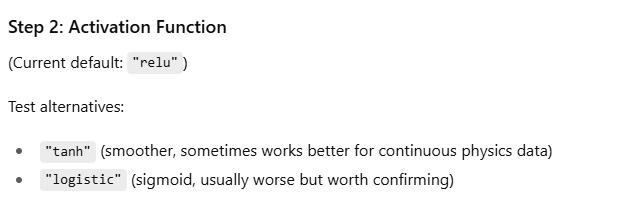


In [ ]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)


mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500, random_state=42))
    ])




models = {
    "MLP_with_(256,128,64)": mlp


}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for name, model in models.items():
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = model # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 25.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print(f"\n Classification Report For Prediction using Model {name}")
    print(classification_report(true_labels, pred_labels, digits=4))


# Comparision Report of all models


In [ ]:
# Convert reports to DataFrame
df_reports = pd.DataFrame(all_reports)

# Save to CSV for later comparison
# df_reports.to_csv("classification_reports_all.csv", index=False)

print("\n All classification reports saved to classification_reports_all")

# Filter only macro avg rows (so we compare at a summary level)
df_compare = df_reports[df_reports["Class"] == "macro avg"]

print("\n Quick Comparison (Macro Avg across models, phases & grid ranges):")
print(df_compare[[
    "Model", "Phase", "precision", "recall", "f1-score",
    "U_min","U_max","mu_min","mu_max"
]])




print(df_reports)










In [ ]:
# --- 1) Ranking per model & range ---
df_summary = (
    df_compare.groupby(["Model","U_max","mu_max"])[["precision", "recall", "f1-score"]]
    .mean()
    .sort_values("f1-score", ascending=False)
    .reset_index()
)

print("\n🏆 Model Ranking (by mean macro F1 across test+prediction, grouped by extrapolation range):")
print(df_summary)

In [ ]:

# --- 2) Best F1 per model ---
df_best = (
    df_summary.groupby("Model", group_keys=False)   # ✅ avoids the warning
    .apply(lambda g: g.loc[g["f1-score"].idxmax()])
    .reset_index(drop=True)
)

print("\n⭐ Best Performing Range per Model:")
print(df_best[["Model","U_max","mu_max","precision","recall","f1-score"]])
